# <center>CITS5017 Project 1<center>
<center>Allison Lau (23123849)<center>

# Import packages

In [9]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW, SGD
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (InputLayer, Conv2D, MaxPool2D, Flatten, Dense, 
                                     Dropout, BatchNormalization, GlobalAveragePooling2D)

# Load Image Dataset

In [2]:
def load_data(pickle_file):
    with open(pickle_file, "rb") as f:
        data_set = pickle.load(f)
    return data_set[b"data"], data_set[b"labels"], data_set[b"class_names"]

def resize_images(images, size=(96, 96)):
    images_resized = tf.image.resize(images, size) / 255.0 # Normalise pixel values
    return images_resized

# Call load_data to build the training and validation sets
X_train, y_train, class_names = load_data("train.pkl")
X_val, y_val, _ = load_data("val.pkl")

# Shuffle training and validation data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

# Check shape of data : Image size = (64, 64, 3)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# Resize images for MobileNetV2 model : Image size = (96, 96, 3)
X_train_resized = resize_images(X_train)
X_val_resized = resize_images(X_val)

# Check shape after resizing
print(f"Resized Training data shape: {X_train_resized.shape}")
print(f"Resized Validation data shape: {X_val_resized.shape}")

Training data shape: (2000, 64, 64, 3)
Validation data shape: (500, 64, 64, 3)
Resized Training data shape: (2000, 96, 96, 3)
Resized Validation data shape: (500, 96, 96, 3)


# Tasks

## (i) Display 20 sample images from training set and validation set

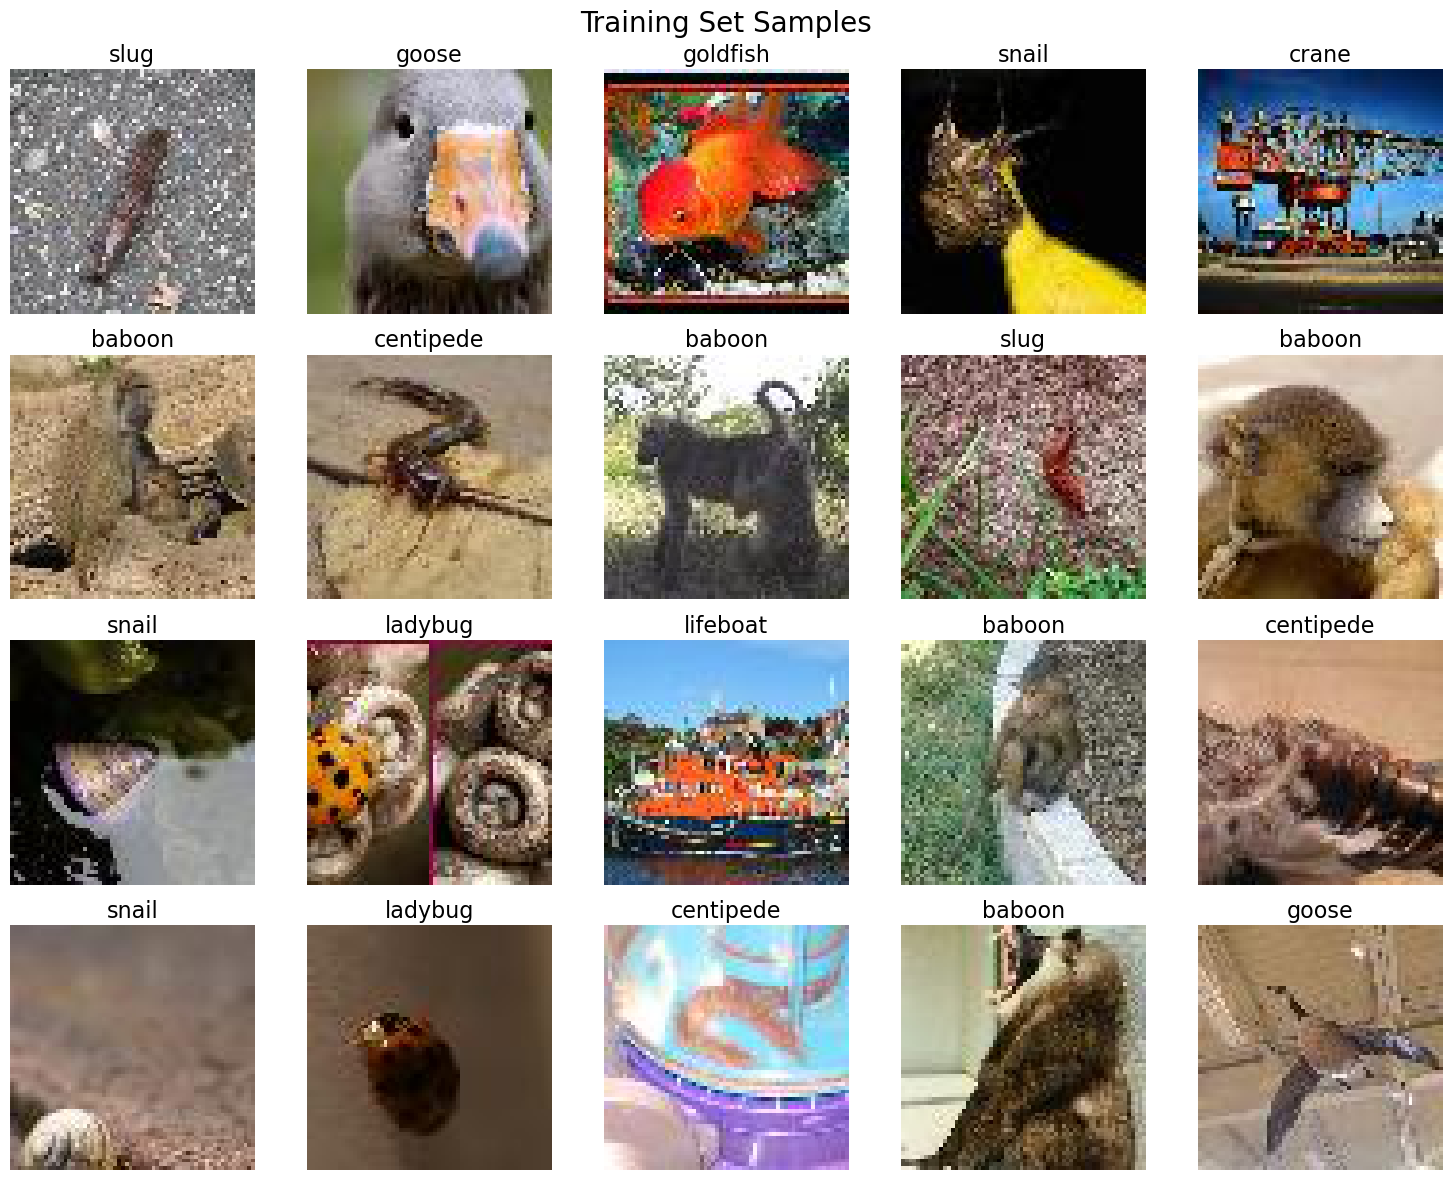

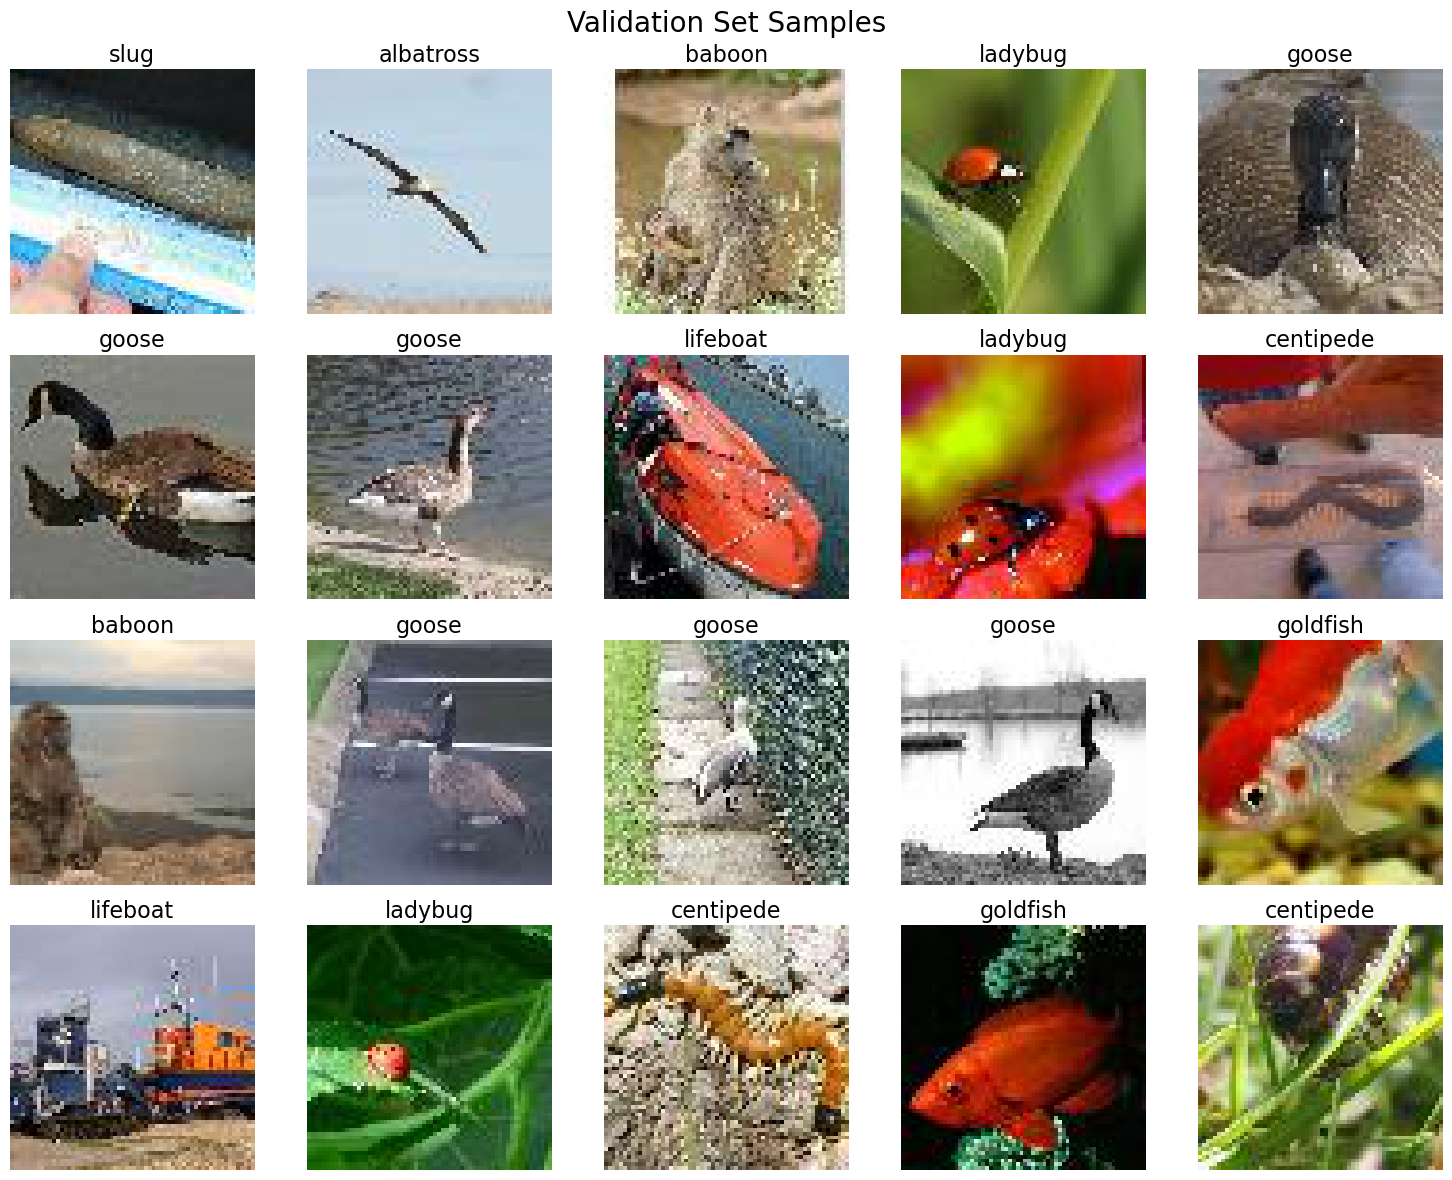

In [10]:
# Function to display sample images from the dataset
def displayImages(images, labels, class_names, num_samples, title, preds=None, condition_indices=None):
    if condition_indices is None: # Sample random images
        indices = np.random.choice(images.shape[0], num_samples, replace=False)
        sampled_labels = labels[indices]
    else:
        indices = np.random.choice(condition_indices, num_samples, replace=False)
        if len(preds) == 2: # Has both model's predictions
            sampled_labels_cnn = preds[0][indices]
            sampled_labels_mnv2 = preds[1][indices]
            sampled_labels = labels[indices]
        else: # Has only one model's predictions
            sampled_labels = preds[indices]

    sampled_images = images[indices]

    num_rows = num_samples // 5
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))

    # Display images if given model's predictions
    if preds is not None and len(preds) == 2:
        for i, (image, label, label_cnn, label_mnv2) in enumerate(zip(sampled_images, sampled_labels, sampled_labels_cnn, sampled_labels_mnv2)):
            row = i // 5
            col = i % 5
            ax = axes[row, col]
            ax.imshow(image)
            title_text = f"True: {class_names[label]}\nCNN: {class_names[label_cnn]}\nMobileNetV2: {class_names[label_mnv2]}"
            ax.set_title(title_text, fontsize=16)
            ax.axis("off")
    # Display random sample images
    else:
        for i, (image, label) in enumerate(zip(sampled_images, sampled_labels)):
            row = i // 5
            col = i % 5
            ax = axes[row, col]
            ax.imshow(image)
            ax.set_title(class_names[label], fontsize=16)
            ax.axis("off")
    
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Display sample images from the training and validation sets
displayImages(X_train, y_train, class_names, 20, "Training Set Samples")
displayImages(X_val, y_val, class_names, 20, "Validation Set Samples")

## (ii) Implementation of CNN Model

### Design of CNN Architecture
- **Activation Function**: `ReLU` activation function was used for the convolutional layers and dense layers to introduce non-linearity to the model, helping it to learn complex patterns in the data. `Softmax` activation function was used for the output layer to output the probability distribution of the classes in a multi-class classification problem.
and `Softmax` for output layer
- **Kernel Initializer**: `He Normal` initialisation was used for the convolutional layers and dense layers to initialise the weights of the network. This initialisation method was chosen because it works well with `ReLU` activation function.

In [11]:
# Function to create a CNN model
def create_cnn(kernel_size, num_kernels, dropout_rate):
    DefaultConv2D = partial(Conv2D, kernel_size=num_kernels, padding="same", activation="relu", 
                            kernel_initializer="he_normal", kernel_regularizer=l2(0.01))

    model = Sequential([
        # Input Layer
        InputLayer(shape=[64, 64, 3]),
        
        # Convolutional Layer 1
        BatchNormalization(),
        DefaultConv2D(filters=num_kernels, kernel_size=kernel_size),
        MaxPool2D(pool_size=3),
        
        # Convolutional Layer 2
        BatchNormalization(),
        DefaultConv2D(filters=num_kernels*2, kernel_size=kernel_size),
        MaxPool2D(pool_size=3),
        
        # Convolutional Layer 3
        BatchNormalization(),
        DefaultConv2D(filters=num_kernels*4, kernel_size=kernel_size),
        MaxPool2D(pool_size=3),

        # Flatten and Fully Connected Layers
        Flatten(),
        Dense(units=128, activation="relu", kernel_initializer="he_normal"),
        Dropout(dropout_rate),
        
        Dense(units=64, activation="relu", kernel_initializer="he_normal"),
        Dropout(dropout_rate),
        
        # Output Layer
        Dense(units=len(class_names), activation="softmax")
    ])
    
    return model

### Train CNN Model Functions
- **Optimizer**: `AdamW` optimizer was used with a learning rate of 0.001. It is an improved version of the Adam optimizer that incorporates weight decay (L2 regularization) , which reduces the size of the model's weights at each training iteration.
- **Loss Function**: `sparse_categorical_crossentropy` loss function was used as this is a multi-class classification problem where the target labels are integers. It provides a measure of how well the model's predicted probabilities match the true distribution of the target labels.
- **Learning Rate Scheduler**: `Performance Scheduling` was used via `ReduceLROnPlateau` callback. It reduces the learning rate by a factor when the error stops dropping, which helps the model to converge effectively by taking smaller steps towards the optimal solution.

In [12]:
# Function to train CNN model
def train_cnn(model, num_epochs=100):
    # Compile model with a learning rate schedule
    optimizer = AdamW(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Train the model with early stopping
    lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=num_epochs,
                            validation_data=(X_val, y_val),
                            callbacks=[lr_scheduler, early_stopping])
    end_time = time.time()
    train_time = end_time - start_time
    return model, history, train_time

# Function to plot learning curves on same figure
def plot_learning_curves(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot accuracy graph
    axs[0].plot(history.history['accuracy'], label='Training Set')
    axs[0].plot(history.history['val_accuracy'], label='Validation Set')
    axs[0].set_title('Accuracy over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    # Plot loss graph
    axs[1].plot(history.history['loss'], label='Training Set')
    axs[1].plot(history.history['val_loss'], label='Validation Set')
    axs[1].set_title('Loss over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    fig.suptitle('Learning Curves', fontsize=16)
    plt.tight_layout()
    plt.show()

### Evaluate Model Functions

In [13]:
# Function to display confusion matrix
def display_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)
    plt.show()

# Function to evaluate a model
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Perform predictions on training and validation sets
    y_train_pred = np.argmax(model.predict(X_train), axis=1)
    y_val_pred = np.argmax(model.predict(X_val), axis=1)
    
    # Compute prediction accuracy and confusion matrix
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    train_cm = confusion_matrix(y_train, y_train_pred)
    val_cm = confusion_matrix(y_val, y_val_pred)
    
    # Print and display results
    print(f"Training Accuracy: {train_accuracy:.4f}")
    display_confusion_matrix(train_cm, "Training Confusion Matrix")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    display_confusion_matrix(val_cm, "Validation Confusion Matrix")
    
    return y_train_pred, y_val_pred

### Manual Hyperparameter Tuning

Objective is to manually explore and tune the following hyperparameters:
- Kernel size
- Number of kernels
- Dropout rate

#### Hyperparameter Grid Settings
- Kernel size: [3, 5]
- Number of kernels: [32, 64]
- Dropout rate: [0.3, 0.5]

#### Hyperparameter Tuning Code
Below is the code for hyperparameter tuning.
```python
from itertools import product

# Hyperparameter grids
kernel_sizes = [3, 5]
num_kernels = [32, 64]
dropout_rates = [0.3, 0.5]

log = open("log.txt", "a", encoding="utf-8")
# Loop through all combinations of hyperparameters
for kernel_size, num_kernel, dropout_rate in product(kernel_sizes, num_kernels, dropout_rates):
    # Create and train the model
    model = create_cnn(kernel_size, num_kernel, dropout_rate)
    model, history, train_time = train_cnn(model, num_epochs=100)
    
    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(X_val, y_val)
    
    print(f"Testing kernel_size={kernel_size}, num_kernels={num_kernel}, dropout_rate={dropout_rate}")
    log.write(f"Testing kernel_size={kernel_size}, num_kernels={num_kernel}, dropout_rate={dropout_rate}\n")
    print(f"- Validation Accuracy: {val_acc:.2f}\n- Validation Loss: {val_loss:.2f}\n- Training Time: {train_time:.2f} seconds\n")
    log.write(f"- Validation Accuracy: {val_acc:.2f}\n- Validation Loss: {val_loss:.2f}\n- Training Time: {train_time:.2f} seconds\n")
    
    # Save the model and history for further analysis if needed
    model.save(f"cnn_kernel_{kernel_size}_kernels_{num_kernel}_dropout_{dropout_rate}.keras")
    
log.close()
```

#### Optimal Hyperparameter Values
Findings from hyperparameter tuning are as follows:
- Kernel size:
- Number of kernels:
- Dropout rate:

Optimal hyperparameter values are:
- Kernel size: 
- Number of kernels: 
- Dropout rate: 

## (iii) Test CNN Model Implementation

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_78          │ (None, 64, 64, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 21, 21, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,214 (657.09 KB)

 Trainable params: 168,016 (656.31 KB)

 Non-trainable params: 198 (792.00 B)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1484 - loss: 7.3308 - val_accuracy: 0.1560 - val_loss: 6.2335 - learning_rate: 0.0010
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3033 - loss: 5.7940 - val_accuracy: 0.3260 - val_loss: 5.3114 - learning_rate: 0.0010
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3406 - loss: 5.0946 - val_accuracy: 0.4480 - val_loss: 4.5633 - learning_rate: 0.0010
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3986 - loss: 4.4243 - val_accuracy: 0.4640 - val_loss: 4.0488 - learning_rate: 0.0010
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4379 - loss: 3.8526 - val_accuracy: 0.4660 - val_loss: 3.5897 - learning_rate: 0.0010
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4659 - loss: 3.4625 - val_accuracy: 0.4820 - val_loss: 3.2364 - learning_rate: 0.0010
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5032 - loss: 3.0499 - 

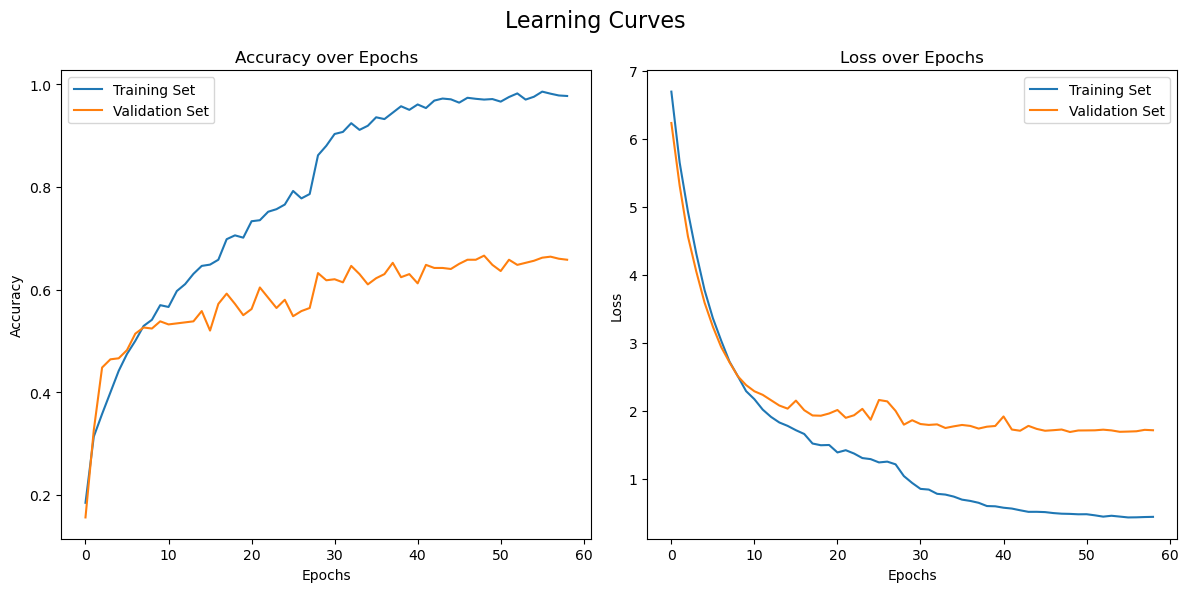

In [44]:
# Training CNN Model
cnn_model_file = 'Lau_Allison-CNN.keras'

# Optimal hyperparameters
kernel_size = 3
num_kernels = 32
dropout_rate = 0.3
num_epochs = 100

if os.path.exists(cnn_model_file):
    # Load and display model summary
    cnn_model = tf.keras.models.load_model(cnn_model_file)
    print(f"Load '{cnn_model_file}' model successfully")
    
    # Compile the model with a tiny learning rate
    optimizer = AdamW(learning_rate=1e-6)
    cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    cnn_model.summary()

    # Train the model for 1 more epoch
    cnn_history = cnn_model.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val))

else:
    # Create CNN model
    cnn_model = create_cnn(kernel_size, num_kernels, dropout_rate)
    
    # Train CNN model
    cnn_model, cnn_history, time_cnn = train_cnn(cnn_model, num_epochs)
    
    # Save the model
    # cnn_model.save(cnn_model_file)
    print(f"Save '{cnn_model_file}' model successfully")
    print(f"Training time: {time_cnn:.2f} seconds")

    # Plot learning curves
    plot_learning_curves(cnn_history)

### Evaluation of CNN Model

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Training Accuracy: 1.0000


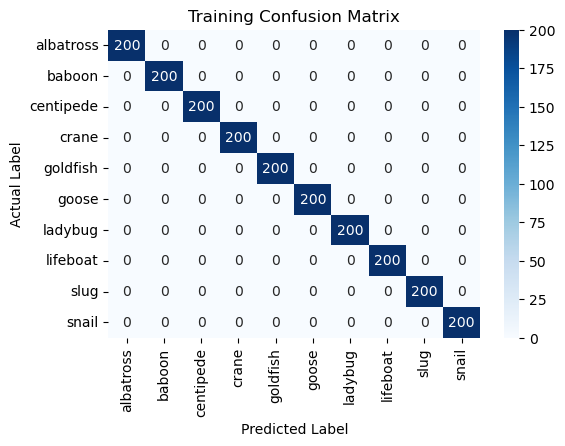

Validation Accuracy: 0.6660


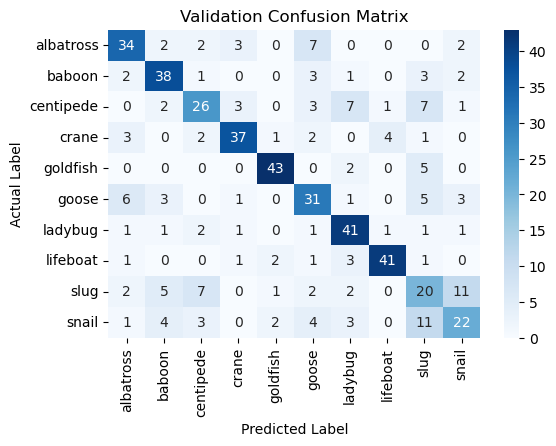

In [45]:
# Evaluate CNN model
cnn_train_pred, cnn_val_pred = evaluate_model(cnn_model, X_train, y_train, X_val, y_val)

## Display samples of correct and incorrect predictions

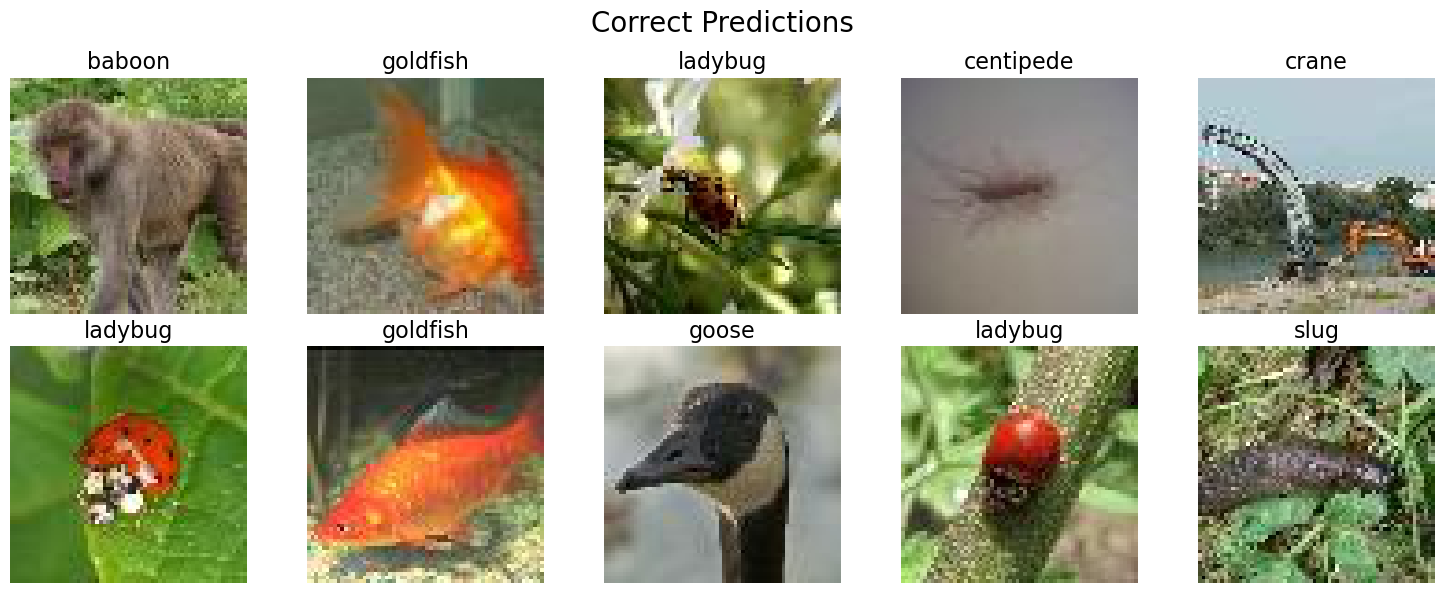

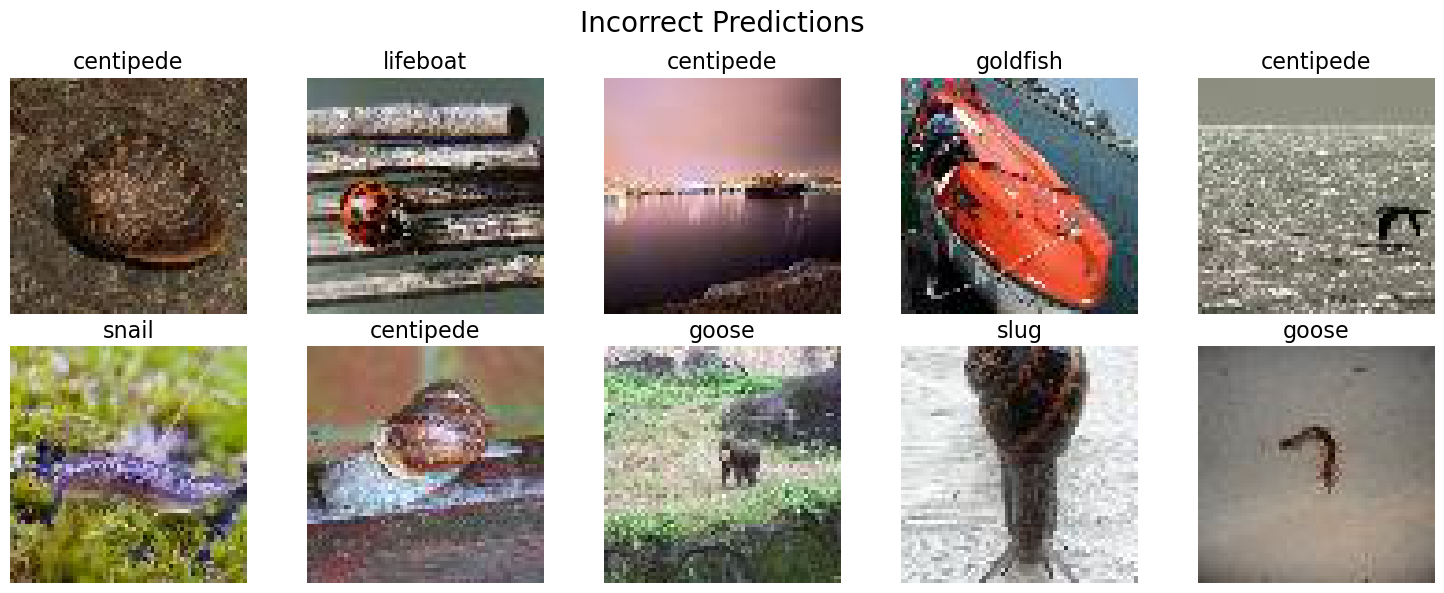

In [12]:
correct_indices = np.where(cnn_val_pred == y_val)[0]
displayImages(X_val, y_val, class_names, 10, "Correct Predictions", 
              preds=cnn_val_pred, condition_indices=correct_indices)

incorrect_indices = np.where(cnn_val_pred != y_val)[0]
displayImages(X_val, y_val, class_names, 10, "Incorrect Predictions", 
              preds=cnn_val_pred, condition_indices=incorrect_indices)

## (iv) Transfer Learning using MobileNetV2

### Design of Transfer Learning Model

In [13]:
# Function to create MobileNetV2 model with modified top layers
def create_mobilenetv2(input_shape=(96, 96, 3), num_classes=10):
    base_model = MobileNetV2(input_shape=input_shape, weights="imagenet", include_top=False)
    average = GlobalAveragePooling2D(name='global_avg_pool')(base_model.output)
    dense = Dense(units=128, activation='relu', name='dense_128')(average)
    dropout = Dropout(0.5)(dense)
    output = Dense(units=num_classes, activation='softmax', name='output_layer')(dropout)
    model = Model(inputs=base_model.input, outputs=output)
    
    return base_model, model

# Function to retrain MobileNetV2 model with transfer learning
def train_mobilenetv2(base_model, model):
    # Freeze layers from base model
    for layer in base_model.layers:
        layer.trainable = False

    # Train model for few epochs
    start_time = time.time()
    optimizer = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(X_train_resized, y_train, epochs=5, validation_data=(X_val_resized, y_val))
    
    # Unfreeze layer 90 onwards
    for layer in base_model.layers[90:]:
        layer.trainable = True
    
    # Train for another 30 epochs with low learning rate
    optimizer = SGD(learning_rate=1e-4, momentum=0.9) # low learning rate
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(X_train_resized, y_train, epochs=30, validation_data=(X_val_resized, y_val))
    end_time = time.time()
    train_time = end_time - start_time
    return model, history, train_time

# Function to display only first and last 5 layers
def display_5_layers(model):
    print("First 5 Layers:")
    first_1 = model.layers[0].name
    first_5 = model.layers[5].name
    model.summary(line_length=100, layer_range=[first_1, first_5])
    
    print("Last 5 Layers:")
    last_1 = model.layers[-1].name
    last_5 = model.layers[-5].name
    model.summary(line_length=100, layer_range=[last_1, last_5])

### Transfer Learning

Model: "mobilenetv2_1.00_96"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

First 5 Layers:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)  │ (None, 96, 96, 3)       │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Conv1 (Conv2D)              │ (None, 48, 48, 32)      │            864 │ input_layer_5[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ bn_Conv1                    │ (None, 48, 48, 32)      │            128 │ Conv1[0][0]             │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Conv1_relu (ReLU)           │ (None, 48, 48, 32)      │              0 │ bn_Conv1[0][0]          │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ expanded_conv_depthwise     │ (None, 48, 48, 32)      │            288 │ Conv1_relu[0][0]        │
│ (DepthwiseConv2D)           │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ expanded_conv_depthwise_BN  │ (None, 48, 48, 32)      │            128 │ expanded_conv_depthwis… │
│ (BatchNormalization)        │                         │                │                         │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 2,389,130 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

Last 5 Layers:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ out_relu (ReLU)             │ (None, 3, 3, 1280)      │              0 │ Conv_1_bn[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ global_avg_pool             │ (None, 1280)            │              0 │ out_relu[0][0]          │
│ (GlobalAveragePooling2D)    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dense_128 (Dense)           │ (None, 128)             │        163,968 │ global_avg_pool[0][0]   │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dropout_7 (Dropout)         │ (None, 128)             │              0 │ dense_128[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ output_layer (Dense)        │ (None, 10)              │          1,290 │ dropout_7[0][0]         │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 2,389,130 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.4027 - loss: 2.0313 - val_accuracy: 0.7420 - val_loss: 0.7205
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7468 - loss: 0.7636 - val_accuracy: 0.7960 - val_loss: 0.6000
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7842 - loss: 0.6112 - val_accuracy: 0.8120 - val_loss: 0.5373
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8235 - loss: 0.5012 - val_accuracy: 0.8260 - val_loss: 0.5521
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.8542 - loss: 0.4353 - val_accuracy: 0.8020 - val_loss: 0.5649
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.6942 - loss: 0.9136 - val_accuracy: 0.8340 - val_loss: 0.5288
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.7675 - loss: 0.7047 - val_accuracy: 0.8360 - val_loss: 0.5268
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.8385 - loss: 0.5069 - val_accuracy: 0.8460 - val

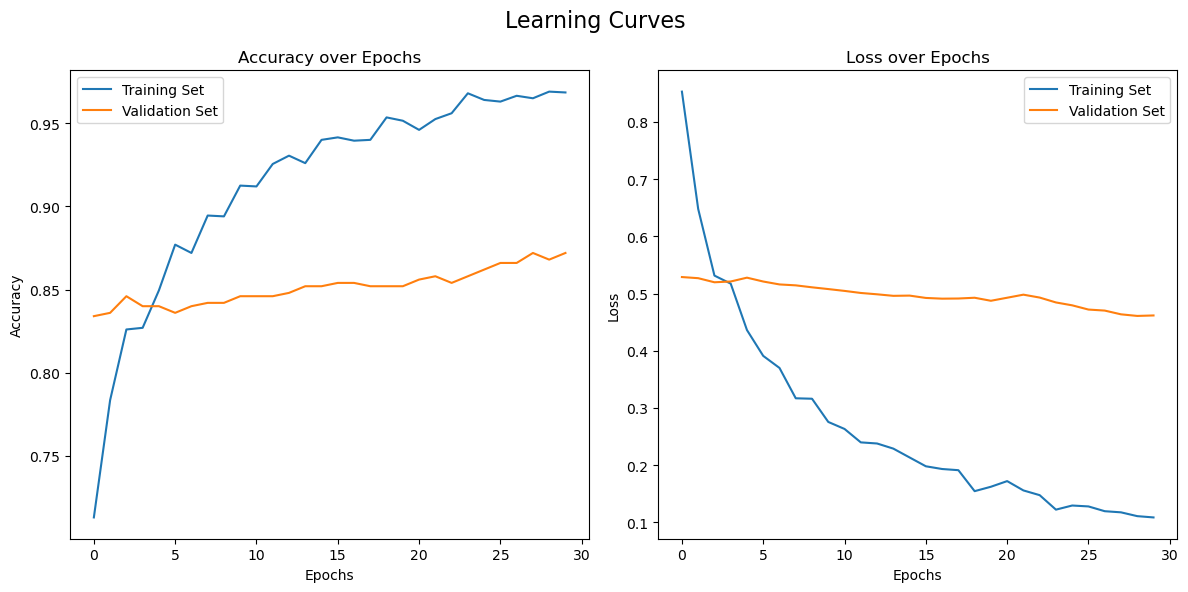

In [18]:
# Training MobileNetV2 model
mnv2_model_file = 'Lau_Allison-MobileNetV2.keras'

# Create and compile the model
base_model, mnv2_model = create_mobilenetv2()

# Inspect base MobileNetV2 model
base_model.summary()

# Inspect retrained MobileNetV2 model
display_5_layers(mnv2_model)

# Transfer learning
mnv2_model, mnv2_history, time_mnv2 = train_mobilenetv2(base_model, mnv2_model)

# Save the model
mnv2_model.save(mnv2_model_file)
print(f"Save '{mnv2_model_file}' model successfully")

# Plot learning curves
plot_learning_curves(mnv2_history)

### Evaluation of MobileNetV2 Model

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Training Accuracy: 0.9990


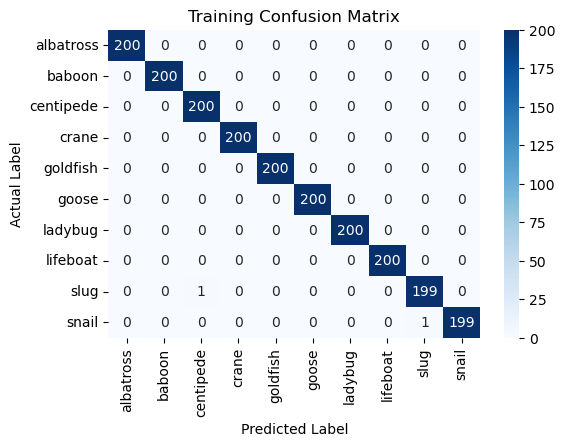

Validation Accuracy: 0.8720


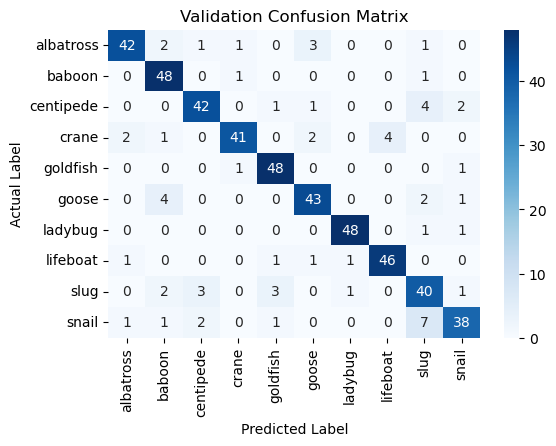

In [19]:
# Evaluate MobileNetV2 model
mnv2_train_pred, mnv2_val_pred = evaluate_model(mnv2_model, X_train_resized, y_train, X_val_resized, y_val)

### Display samples of correct and incorrect predictions

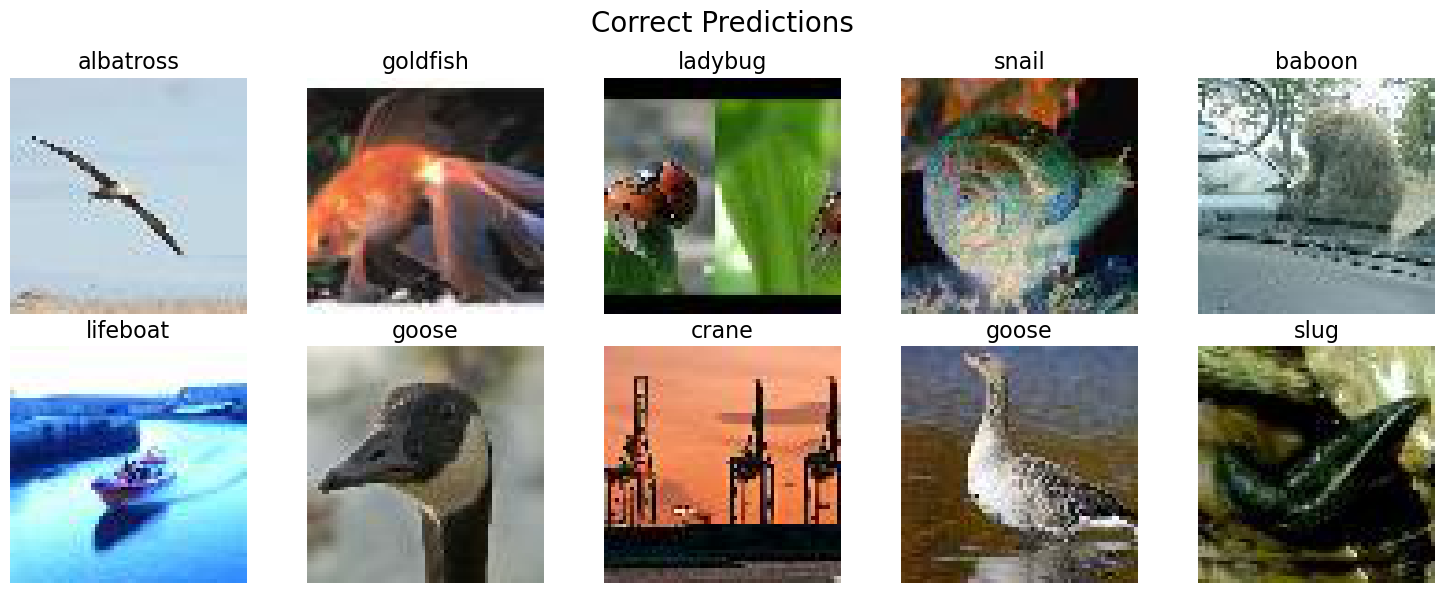

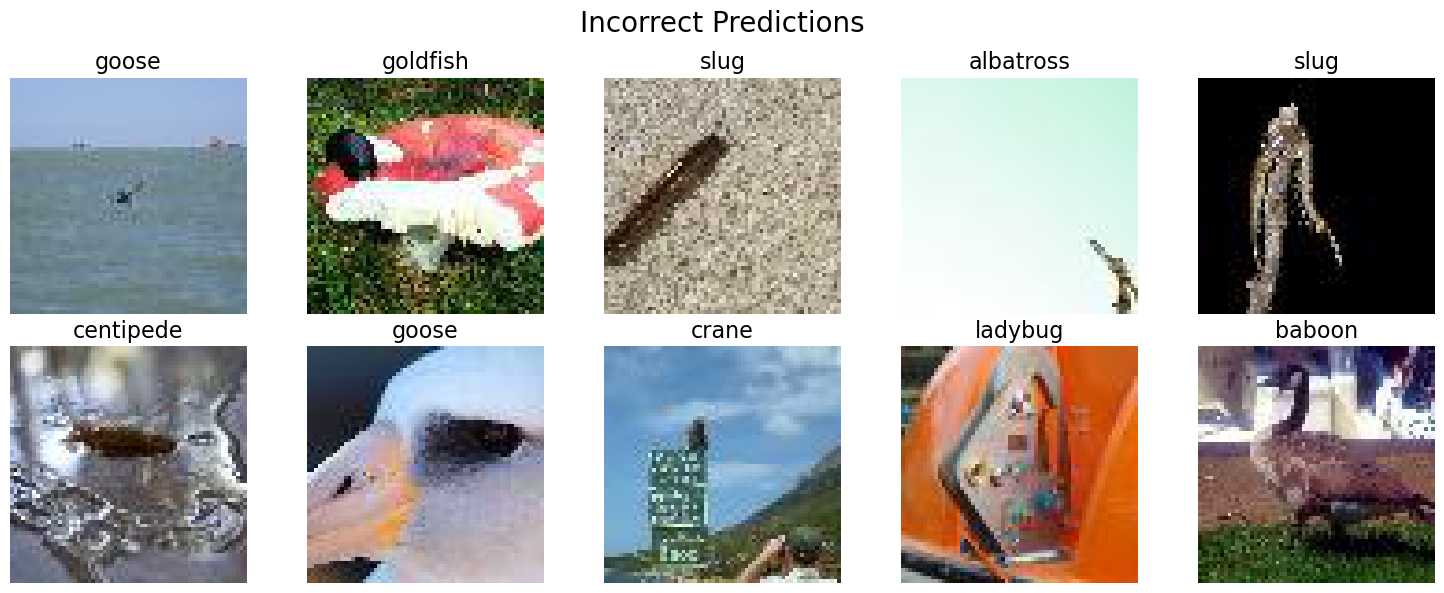

In [20]:
correct_indices = np.where(mnv2_val_pred == y_val)[0]
displayImages(X_val, y_val, class_names, 10, "Correct Predictions", 
              preds=mnv2_val_pred, condition_indices=correct_indices)

incorrect_indices = np.where(mnv2_val_pred != y_val)[0]
displayImages(X_val, y_val, class_names, 10, "Incorrect Predictions", 
              preds=mnv2_val_pred, condition_indices=incorrect_indices)

## (v) Comparisons

### Model Classification Performances

In [21]:
# Function to compute model performance
def model_performance(y_true, y_pred):
    # Overall accuracy
    overall_accuracy = accuracy_score(y_true, y_pred)
    # Accuracy, F1 Score and Precision per class
    accuracy = {}
    for class_label in set(y_true):
        class_indices = [i for i, label in enumerate(y_true) if label == class_label]
        accuracy[class_label] = accuracy_score(
            [y_true[i] for i in class_indices],
            [y_pred[i] for i in class_indices]
        )
    accuracy = [accuracy[class_label] for class_label in range(len(class_names))]
    f1 = f1_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average=None)
    return overall_accuracy, accuracy, f1, precision

def print_per_class(accuracy, f1, precision):
    df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': [f"{res:.2f}" for res in accuracy],
        'F1 Score': [f"{res:.2f}" for res in f1],
        'Precision': [f"{res:.2f}" for res in precision]
    })
    print(df.to_string(index=False))

overall_acc_cnn, acc_cnn, f1_cnn, precision_cnn = model_performance(y_val, cnn_val_pred)
overall_acc_mnv2, acc_mnv2, f1_mnv2, precision_mnv2 = model_performance(y_val, mnv2_val_pred)

print("CNN Model Performance:")
print(f"Overall Accuracy: {overall_acc_cnn:.2f}")
print("Accuracy, F1 Score, Precision per class:")
print_per_class(acc_cnn, f1_cnn, precision_cnn)

print("\nMobileNetV2 Performance:")
print(f"Overall Accuracy: {overall_acc_mnv2:.2f}")
print("Accuracy, F1 Score, Precision per class:")
print_per_class(acc_mnv2, f1_mnv2, precision_mnv2)

CNN Model Performance:
Overall Accuracy: 0.66
Accuracy, F1 Score, Precision per class:
    Class Accuracy F1 Score Precision
albatross     0.72     0.72      0.72
   baboon     0.54     0.62      0.73
centipede     0.44     0.42      0.41
    crane     0.80     0.79      0.78
 goldfish     0.90     0.90      0.90
    goose     0.66     0.61      0.56
  ladybug     0.80     0.79      0.78
 lifeboat     0.80     0.84      0.89
     slug     0.48     0.47      0.45
    snail     0.42     0.42      0.42

MobileNetV2 Performance:
Overall Accuracy: 0.87
Accuracy, F1 Score, Precision per class:
    Class Accuracy F1 Score Precision
albatross     0.84     0.88      0.91
   baboon     0.96     0.89      0.83
centipede     0.84     0.86      0.88
    crane     0.82     0.87      0.93
 goldfish     0.96     0.92      0.89
    goose     0.86     0.86      0.86
  ladybug     0.96     0.96      0.96
 lifeboat     0.92     0.92      0.92
     slug     0.80     0.75      0.71
    snail     0.76     0.

### Model Complexities

In [22]:
def model_complexity(model):
    num_params = model.count_params()
    num_layers = len(model.layers)
    return num_params, num_layers

num_params_cnn, num_layers_cnn = model_complexity(cnn_model)
num_params_mnv2, num_layers_mnv2 = model_complexity(mnv2_model)

print("CNN Model Complexity:")
print(f"Number of Parameters: {num_params_cnn}")
print(f"Number of Layers: {num_layers_cnn}")
print(f"Training Time: {time_cnn:.2f} seconds")

print("\nMobileNetV2 Model Complexity:")
print(f"Number of Parameters: {num_params_mnv2}")
print(f"Number of Layers: {num_layers_mnv2}")
print(f"Training Time: {time_mnv2:.2f} seconds")

CNN Model Complexity:
Number of Parameters: 511702
Number of Layers: 15
Training Time: 164.86 seconds

MobileNetV2 Model Complexity:
Number of Parameters: 2423242
Number of Layers: 158
Training Time: 216.99 seconds


### Display images where
- both models predict correctly
- both models predict incorrectly
- CNN predicts correctly but MobileNetV2 predicts incorrectly
- CNN predicts incorrectly but MobileNetV2 predicts correctly

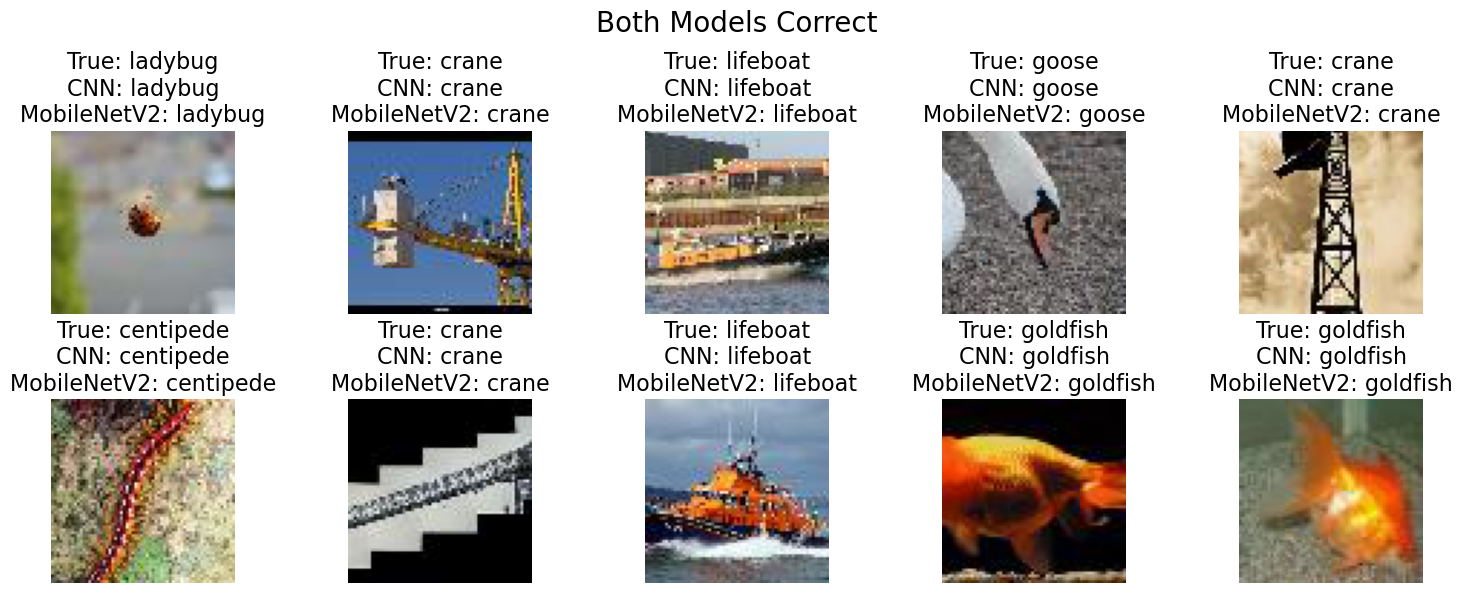

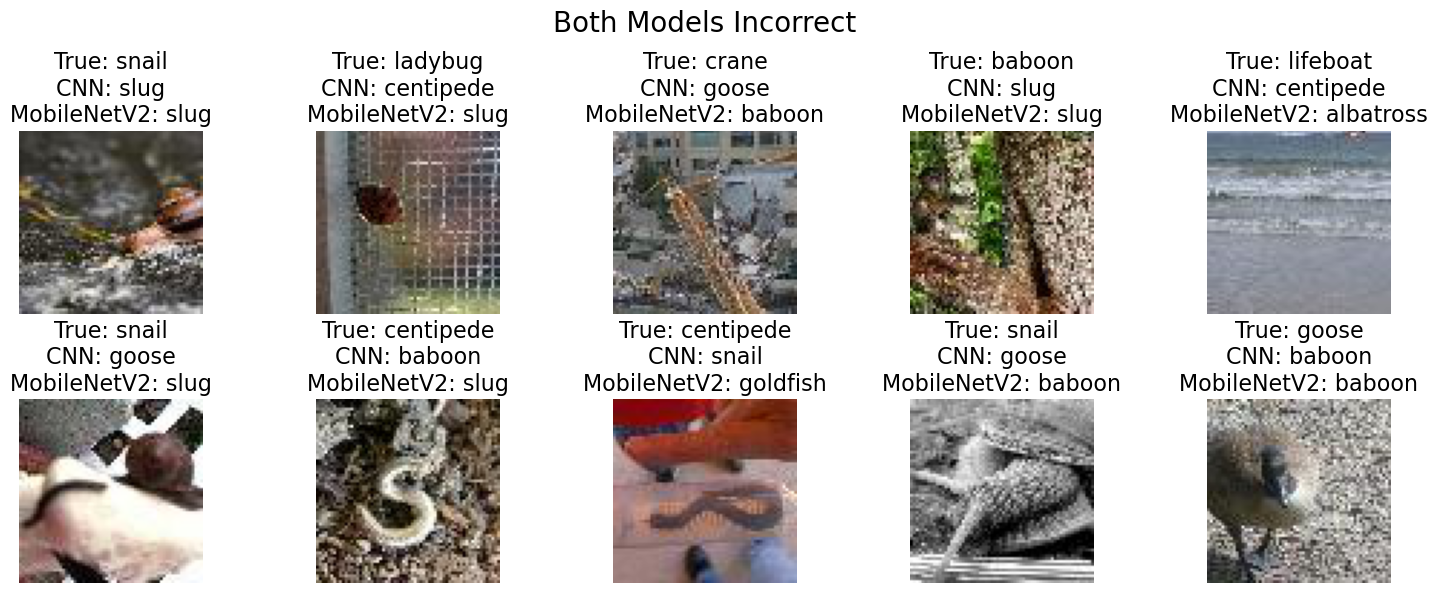

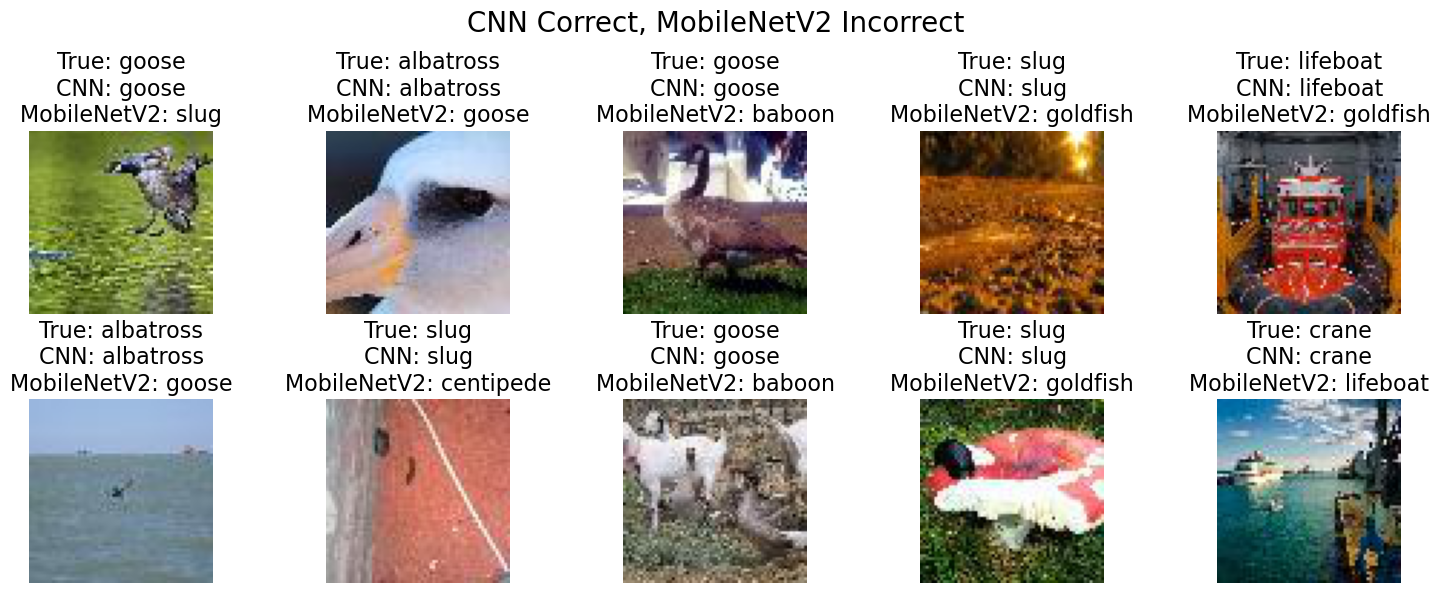

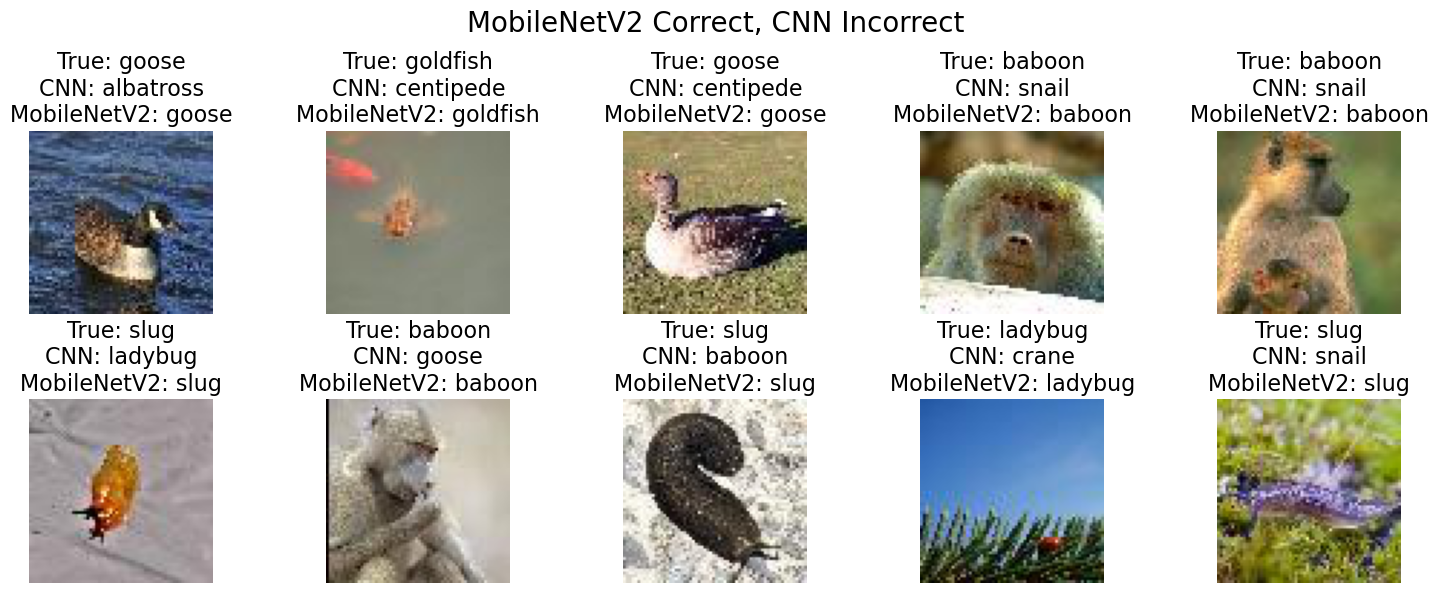

In [23]:
def get_indices(y_true, y_pred_cnn, y_pred_mnv2, condition):
    if condition == 'both_correct':
        indices = np.where((y_true == y_pred_cnn) & (y_true == y_pred_mnv2))[0]
    elif condition == 'both_incorrect':
        indices = np.where((y_true != y_pred_cnn) & (y_true != y_pred_mnv2))[0]
    elif condition == 'cnn_correct_mobilenetv2_incorrect':
        indices = np.where((y_true == y_pred_cnn) & (y_true != y_pred_mnv2))[0]
    elif condition == 'mobilenetv2_correct_cnn_incorrect':
        indices = np.where((y_true == y_pred_mnv2) & (y_true != y_pred_cnn))[0]
    else:
        raise ValueError("Invalid condition")
    return indices

both_correct_indices = get_indices(y_val, cnn_val_pred, mnv2_val_pred, 'both_correct')
both_incorrect_indices = get_indices(y_val, cnn_val_pred, mnv2_val_pred, 'both_incorrect')
only_cnn_correct_indices = get_indices(y_val, cnn_val_pred, mnv2_val_pred, 'cnn_correct_mobilenetv2_incorrect')
only_mnv2_correct_indices = get_indices(y_val, cnn_val_pred, mnv2_val_pred, 'mobilenetv2_correct_cnn_incorrect')
both_predictions = (cnn_val_pred, mnv2_val_pred)

displayImages(X_val, y_val, class_names, 10, "Both Models Correct", 
              preds=both_predictions, condition_indices=both_correct_indices)
displayImages(X_val, y_val, class_names, 10, "Both Models Incorrect",
              preds=both_predictions, condition_indices=both_incorrect_indices)
displayImages(X_val, y_val, class_names, 10, "CNN Correct, MobileNetV2 Incorrect",
              preds=both_predictions, condition_indices=only_cnn_correct_indices)
displayImages(X_val, y_val, class_names, 10, "MobileNetV2 Correct, CNN Incorrect",
              preds=both_predictions, condition_indices=only_mnv2_correct_indices)